<a href="https://colab.research.google.com/github/Robert2004-AI/LearnComputerVisionWithMithun/blob/main/ADL_Assigment01_Task4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group No - 44

**Group Member Names:**

SAKTHI R (2023aa05940)

ROBERTSEKAR R (2023aa05823)

RAVISHANKAR R (2023aa05171

NIMBALKAR PRITEESH DADASAHEB (2023aa05950)

# Task 4:

Train a deep convolutional autoencoder with MNIST dataset and using extracted features train a MLP classifier with 7 outputs (7 segment LED display) that are representative of 10 digits. For example images of "0" will be classified as

   1

1    1

   1    

1     1

   1

7 will be "classified" as

   1

0    1

   0    

0    1

   0

Generate the confusion matrix for the corresponding test dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.datasets import fetch_openml
from tensorflow.keras.utils import to_categorical

# ---- Load MNIST Dataset ----
def load_data():
    """
    Load the MNIST dataset from OpenML, normalize the pixel values to [0, 1],
    and split into training and testing sets.
    """
    mnist = fetch_openml('mnist_784', version=1)  # Fetch MNIST dataset
    X = mnist.data / 255.0  # Normalize pixel values to [0, 1]
    y = mnist.target.astype(int)  # Convert target labels to integers
    # Split the data into training (70%) and testing (30%) sets
    return train_test_split(X, y, test_size=0.3, random_state=42)

X_train, X_test, y_train, y_test = load_data()



Task 4: Deep Autoencoder Features for MLP Classification
Extracting Features from Deep Autoencoder
Training Deep Convolutional Autoencoder...
Epoch 1/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.1009
Epoch 2/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0315
Epoch 3/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0216
Epoch 4/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0175
Epoch 5/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0152
Epoch 6/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0137
Epoch 7/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0127
Epoch 8/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0120
Epoch 9/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0115
Epoch 10/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0112
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training MLP on Extracted Features
MLP Test Accuracy: 0.9776
Mapped Classes in y_test_segments: [2 3 

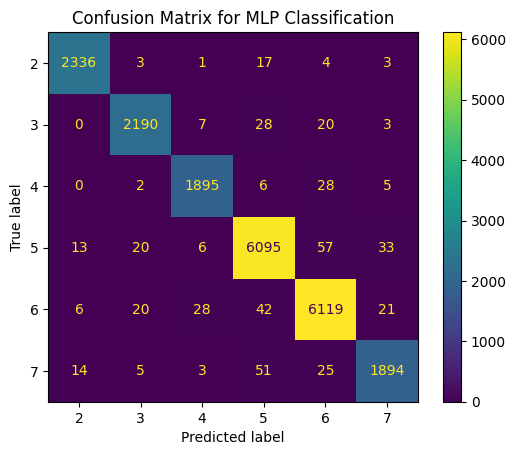

In [2]:
print("\nTask 4: Deep Autoencoder Features for MLP Classification")


def build_deep_autoencoder(input_shape, latent_dim):
    """
    Build a deep convolutional autoencoder model.

    Parameters:
        input_shape (tuple): Shape of the input data (e.g., (28, 28, 1) for MNIST images).
        latent_dim (int): Dimensionality of the latent (compressed) space.

    Returns:
        autoencoder (Model): Compiled autoencoder model.
    """
    # Input layer for image data with specified shape
    input_layer = layers.Input(shape=input_shape)

    # Encoder: First convolutional layer with 32 filters, 3x3 kernel, ReLU activation, and same padding
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    # Downsampling using max pooling to reduce spatial dimensions
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Encoder: Second convolutional layer with 64 filters, 3x3 kernel, ReLU activation, and same padding
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # Further downsampling using max pooling
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Flatten the feature maps into a 1D vector for the fully connected layer
    x = layers.Flatten()(x)
    # Fully connected layer to compress data into the latent space
    encoded = layers.Dense(latent_dim, activation='relu')(x)
    encoded.name = "dense_2"  # Naming the layer for easier access

    # Decoder: Expand latent representation back to original input shape
    # Fully connected layer to reconstruct the flattened input
    decoder_input = layers.Reshape((latent_dim,))(encoded)
    decoder = layers.Dense(np.prod(input_shape), activation='sigmoid')(decoder_input)
    # Reshape the flattened output back into the original input dimensions
    decoded = layers.Reshape(input_shape)(decoder)

    # Create the autoencoder model combining encoder and decoder
    autoencoder = models.Model(input_layer, decoded)

    # Compile the model with Adam optimizer and Mean Squared Error (MSE) loss
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

# Function to train an MLP classifier on extracted features
def train_mlp(X_train_features, y_train, n_classes=7):
    """
    Train a Multi-Layer Perceptron (MLP) classifier using extracted features.

    Parameters:
        X_train_features (ndarray): Features extracted from the autoencoder's encoder.
        y_train (ndarray): Target labels for training.
        n_classes (int): Number of target classes (default is 7 for the 7-segment display).

    Returns:
        mlp (MLPClassifier): Trained MLP classifier.
    """
    mlp = MLPClassifier(hidden_layer_sizes=(128,), activation='relu', max_iter=500)
    mlp.fit(X_train_features, y_train)  # Train the MLP on extracted features
    return mlp

# Function to map MNIST digit labels to corresponding 7-segment display classes
def map_to_segments(y):
    """
    Map MNIST digit labels (0-9) to corresponding 7-segment display classes.

    Parameters:
        y (ndarray): Array of digit labels.

    Returns:
        ndarray: Array of mapped labels for 7-segment display.
    """
    # Mapping of MNIST digits to 7-segment display classes
    segment_map = {0: 6, 1: 2, 2: 5, 3: 5, 4: 4, 5: 5, 6: 6, 7: 3, 8: 7, 9: 6}
    return np.array([segment_map[d] for d in y])  # Apply mapping to each label

print("Extracting Features from Deep Autoencoder")
latent_dim = 50  # Set the latent space dimensionality
# Use the encoder (first part of the deep autoencoder) to extract latent features
# Reshape training and test data into 4D format for convolutional layers
# Each image is reshaped to (28, 28, 1) to represent height, width, and channels
X_train_reshaped = X_train.values.reshape(-1, 28, 28, 1)
X_test_reshaped = X_test.values.reshape(-1, 28, 28, 1)

# Build the deep convolutional autoencoder
deep_autoencoder = build_deep_autoencoder((28, 28, 1), latent_dim)

# Train the autoencoder using the reshaped training data
# The goal is to reconstruct the input images while learning a compressed latent representation
print("Training Deep Convolutional Autoencoder...")
deep_autoencoder.fit(X_train_reshaped, X_train_reshaped, epochs=10, batch_size=256)

encoder = models.Model(deep_autoencoder.input, deep_autoencoder.get_layer(index=-2).output)
X_train_features = encoder.predict(X_train_reshaped)  # Extract features from training data
X_test_features = encoder.predict(X_test_reshaped)  # Extract features from test data

# Map digit labels to 7-segment display classes
y_train_segments = map_to_segments(y_train)
y_test_segments = map_to_segments(y_test)

print("Training MLP on Extracted Features")
# Train the MLP on extracted features and mapped labels
mlp = train_mlp(X_train_features, y_train_segments)

# Evaluate the MLP on the test set
test_accuracy = mlp.score(X_test_features, y_test_segments)
print(f"MLP Test Accuracy: {test_accuracy:.4f}")

# Import confusion matrix utilities
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Check the distribution of mapped test labels (ensures no missing classes)
print("Mapped Classes in y_test_segments:", np.unique(y_test_segments))

# Predict the test set using the trained MLP
y_pred_segments = mlp.predict(X_test_features)

# Generate a confusion matrix to evaluate classification performance
cm = confusion_matrix(y_test_segments, y_pred_segments)

# Display the confusion matrix with appropriate labels
unique_classes = np.unique(y_test_segments)  # Dynamically find unique classes
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_classes)
disp.plot()  # Plot the confusion matrix
plt.title("Confusion Matrix for MLP Classification")  # Add title to the plot
plt.show()  # Show the confusion matrix plot
